# HyP3 Burst InSAR Workflow with MintPy Prep
This notebook automates the process of searching for Sentinel-1 Burst SLC data, selecting pairs, submitting InSAR jobs to ASF HyP3, managing results, and preparing them for MintPy time-series analysis.

If you want to try to experiment with this, please make sure to make your own copy into a separate directory.

### Prerequisites
- **Kernel**: Ensure you are using the `InSAR Stable (Py 3.12) (Local)` kernel.
- **Authentication**: A valid `.netrc` file or active ASF credentials are required for HyP3 access.

### If you're interested in learning more, reach out to Tyler or Alex N. about this.
- Also feel free to browse this [GitHub repository](https://github.com/parosen/Geo-SInC/tree/main/EarthScope2023) which includes scripts, Jupyter Notebooks, and information from the ISCE+ EarthScope workshop about InSAR processing.
- Additionally, if you want to install the workshop materials on your own machine for viewing purposes or install in this Jupyter Lab, we can help you set that up [link provided here](https://github.com/ASFOpenSARlab/earthscope-insar-image).

In [1]:
import sys
import os
from pathlib import Path

def notebook_health_check():
    # 1. Check Kernel
    if 'mintpy' not in sys.executable:
        print("❌ WARNING: You are not using the 'mintpy_stable' kernel. Some commands will fail.")
    else:
        print("✅ Kernel: mintpy_stable detected.")

    # 2. Check Credentials
    netrc_path = Path.home() / ".netrc"
    if not netrc_path.exists():
        print("⚠️ WARNING: .netrc file not found. You will need to authenticate with ASF manually.")
    else:
        print("✅ ASF Credentials (.netrc) detected.")
    
    # 3. Check for projection tool
    try:
        import pyproj
        print("✅ Pyproj installed.")
    except ImportError:
        print("⚠️ Pyproj not found. Running installation...")
        !pip install pyproj

notebook_health_check()

✅ Kernel: mintpy_stable detected.
✅ ASF Credentials (.netrc) detected.
✅ Pyproj installed.


In [2]:
import os
import sys
import asf_search as asf
import hyp3_sdk as sdk
import zipfile
import numpy as np
import h5py
import matplotlib.pyplot as plt
import rasterio
import leafmap
import folium
import branca.colormap as cm
from folium import plugins
from rasterio.crs import CRS
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
from typing import List, Union
from osgeo import gdal
from rasterio.warp import transform_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling

# This ensures that shell commands (!command) can find MintPy tools
env_bin = Path(sys.executable).parent
if str(env_bin) not in os.environ["PATH"]:
    os.environ["PATH"] = f"{env_bin}:{os.environ['PATH']}"

# Initialize HyP3 session
hyp3 = sdk.HyP3()

# Define project paths
download_path = Path('./insar_results')
extract_path = download_path / 'extracted'
mintpy_path = Path('./MintPy')

# Ensure directories exist
download_path.mkdir(exist_ok=True)
extract_path.mkdir(exist_ok=True)
mintpy_path.mkdir(exist_ok=True)

gdal.UseExceptions()

## 1. Initial Data Check (Gating)
Before submitting new jobs, we check if the raw zip files or unzipped products already exist locally.

In [3]:
existing_zips = list(download_path.glob('*.zip'))
skip_processing = len(existing_zips) > 0

if skip_processing:
    print(f"✅ Found {len(existing_zips)} zip files. Gating active: Skipping submission, download, and extraction.")
else:
    print("🚀 No local data found. Proceeding with search and submission.")

✅ Found 22 zip files. Gating active: Skipping submission, download, and extraction.


## 2. Search for Bursts
We define our area of interest (AOI) and search for descending Sentinel-1 Burst SLCs.

- You can generate the aoi by using the Alaska Satellite Facillity (ASF) Data Search Vertex tool at:
[ASF Vertex](https://search.asf.alaska.edu/#/). From here, you can draw a bounding box and copy this output and change your AOI.

- You can change the options based on what satellite, beam mode, dataset, time period, polarization, flight direction, etc. you want to use. The parameters are listed here: [ASF Search Parameters](https://github.com/asfadmin/Discovery-asf_search/tree/master/asf_search/constants).

- Lastly, I filter the search for a specific burst, which you can look at the burst indexes within the ASF Vertex GUI, click "Dataset", and then "S1 Bursts", and then search for your aoi, filter by date period, etc.

In [4]:
aoi = 'POLYGON((-156.8054 71.2831,-156.6993 71.2831,-156.6993 71.3075,-156.8054 71.3075,-156.8054 71.2831))'

opts = {
    'platform': 'SENTINEL-1',
    'beamMode': 'IW',
    'dataset': 'SLC-BURST',
    'start': '2025-05-01T00:00:00Z',
    'end': '2025-10-01T00:00:00Z',
    'polarization': 'VV',
    'flightDirection': 'DESCENDING'
}

results = asf.geo_search(intersectsWith=aoi, **opts)

# Filter for burst index 0 for temporal consistency
filtered_results = [r for r in results if r.properties['burst']['burstIndex'] == 0]
granules = [r.properties['sceneName'] for r in filtered_results]

print(f"Found {len(results)} total results. Filtered to {len(granules)} unique granules.")

Found 24 total results. Filtered to 12 unique granules.


## 3. Pair Selection Logic
Helper function to find the nearest temporal neighbors (secondary images) for a reference image.

Here, I'm only interested in using interferograms with a temporal baseline (repeat) of 12 and 24 days, therefore, I set that between 1 and 25 days. You can change this if you are interested in creating interferograms with longer baselines. This could be ideal for more data, but you will have to make sure that your interferograms are coherent.

In [5]:
def get_nearest_neighbors(granule: str, max_neighbors: int | None = None) -> asf.ASFSearchResults:
    granule_res = asf.granule_search(granule)[-1]
    # Filter for short temporal baselines (e.g., 6 to 24 days)
    stack = reversed([
        item for item in granule_res.stack() 
        if 1 < item.properties['temporalBaseline'] < 25
    ])
    return asf.ASFSearchResults(stack)[:max_neighbors]

## 4. Job Submission
Submits InSAR ISCE Burst jobs to HyP3 if data is missing.

In [6]:
if skip_processing:
    print("Skipping submission: Raw data already exists locally.")
else:
    burst_insar_jobs = sdk.Batch()
    for reference in tqdm(granules, desc="Submitting Jobs"):
        neighbors = get_nearest_neighbors(reference, max_neighbors=2)
        for secondary in neighbors:
            burst_insar_jobs += hyp3.submit_insar_isce_burst_job(
                reference, 
                secondary.properties['sceneName'], 
                name='burst_ex_v2', 
                apply_water_mask=True, 
                looks='10x2'
            )
    print(burst_insar_jobs)

Skipping submission: Raw data already exists locally.


## 5. Download Successful Products
Monitors the HyP3 queue and downloads completed products.

In [7]:
if skip_processing:
    print("Skipping download: Raw data already exists locally.")
else:
    # Note: If this is a new run, you would need to wait for jobs to finish
    burst_insar_jobs = hyp3.refresh(burst_insar_jobs)
    status_counts = Counter(job.status_code for job in burst_insar_jobs)
    print(f"Status Summary: {status_counts}")
    
    succeeded_jobs = burst_insar_jobs.filter_jobs(succeeded=True, running=False, failed=False)
    file_list = succeeded_jobs.download_files(location=str(download_path), create=True)
    print(f"Downloaded {len(file_list)} files.")

Skipping download: Raw data already exists locally.


## 6. Unzip Archives
Extracts HyP3 zip files into organized directories.

In [8]:
if skip_processing:
    print("Skipping extraction: Files are likely already unzipped in the 'extracted' folder.")
else:
    zip_files = list(download_path.glob('*.zip'))
    for zip_path in tqdm(zip_files, desc="Extracting"):
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
        except Exception as e:
            print(f"Error: {e}")
    print("Extraction complete.")

Skipping extraction: Files are likely already unzipped in the 'extracted' folder.


## 7. Prepare Results for MintPy
MintPy requires all input interferograms to have the exact same spatial extent. We calculate the common overlap across all products and clip them accordingly.

In [9]:
def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Calculate the common spatial intersection for a list of GeoTIFFs."""
    corners = [gdal.Info(str(f), format='json')['cornerCoordinates'] for f in file_list]
    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]

def clip_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all MintPy-relevant GeoTIFFs to the common overlap coordinates."""
    files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_conncomp.tif', 
                        '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']
    
    for extension in files_for_mintpy:
        for file in data_dir.rglob(f'*{extension}'):
            # Skip files that are already clipped
            if '_clipped' in file.name:
                continue
                
            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'
            
            # Run GDAL Translate to clip
            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

### 7.1 Gated Clipping Execution
We check for existing `*_clipped.tif` files before running the resource-intensive clipping process.

In [10]:
# Check for existing clipped files
clipped_files = list(extract_path.rglob('*_clipped.tif'))
skip_clipping = len(clipped_files) > 0

if skip_clipping:
    print(f"✅ Found {len(clipped_files)} clipped files. Skipping clipping process.")
else:
    print("✂️ Clipping products to common overlap...")
    # 1. Get list of DEMs to determine overlap
    dem_files = list(extract_path.glob('*/*_dem.tif'))
    if not dem_files:
        print("❌ No unzipped products found. Please run the extraction step.")
    else:
        overlap = get_common_overlap(dem_files)
        # 2. Perform clipping
        clip_hyp3_products_to_common_overlap(extract_path, overlap)
        print("✅ Clipping complete.")

✅ Found 154 clipped files. Skipping clipping process.


## 8. Time-Series Analysis with MintPy
Now that your data is clipped and ready, you can begin the MintPy workflow. Output below is help information for using MintPy.

This help information lists the option to use a custom configuration file (highly recommended), various options, and processing steps.

In [11]:
# Verify MintPy installation and view available options
!smallbaselineApp.py -h

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]

Routine Time Series Analysis for Small Baseline InSAR Stack

positional arguments:
  customTemplateFile    custom template with option settings.
                        ignored if the default smallbaselineApp.cfg is input.

options:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        work directory, (default: ./).
  -g                    generate default template (if it does not exist) and exit.
  -H                    print the default template file and exit.
  -v, --version         print software version and exit
  --plot                plot results [only] without running smallbaselineApp.

steps processing (start/end/dostep):
  Command line options for steps processing with names chosen from the following list:
  
  ['load_data', '

We will start by changing directories to the MintPy directory and setup a new configuration file.

In [12]:
os.chdir('MintPy')
!pwd

/home/jupyter/edc-research-demos/MintPy


In [13]:
# we will now run smallbaselineApp.py with the -g argument to generate a default template
!smallbaselineApp.py -g

--------------------------------------------------
Go to work directory: /home/jupyter/edc-research-demos/MintPy
read default template file: /home/jupyter/edc-research-demos/MintPy/smallbaselineApp.cfg
Go back to directory: /home/jupyter/edc-research-demos/MintPy

################################################
   Normal end of smallbaselineApp processing!
################################################
Time used: 00 mins 0.0 secs



### Let's see what that file looks like
#### This file lists a plethora of options that you can manually change, or even copy and paste into your own custom file.
#### Since there are a lot of options here, it is usually best practice to just copy and paste relevant lines into your own file for ease of readability for what actual changes you decide to make.

#### Creating and editing your custom config file is an iterative process, and usually requires running MintPy multiple times to settle on what exactly you want for you given dataset, requiring knowledge of the study area in general.

In [14]:
!cat smallbaselineApp.cfg

# vim: set filetype=cfg:
##------------------------ smallbaselineApp.cfg ------------------------##
########## computing resource configuration
mintpy.compute.maxMemory = auto #[float > 0.0], auto for 4, max memory to allocate in GB
## parallel processing with dask
## currently apply to steps: invert_network, correct_topography
## cluster   = none to turn off the parallel computing
## numWorker = all  to use all of locally available cores (for cluster = local only)
## numWorker = 80%  to use 80% of locally available cores (for cluster = local only)
## config    = none to rollback to the default name (same as the cluster type; for cluster != local)
mintpy.compute.cluster   = auto #[local / slurm / pbs / lsf / none], auto for none, cluster type
mintpy.compute.numWorker = auto #[int > 1 / all / num%], auto for 4 (local) or 40 (slurm / pbs / lsf), num of workers
mintpy.compute.config    = auto #[none / slurm / pbs / lsf ], auto for none (same as cluster), config name


########## 1. load_d

### Let's create a new config file
#### Generally, I will make a new MintPy directory if I make changes to the config files so that I can track the output changes.
#### Ex.: 1st version = /edc-research-demos/MintPy; maybe a 2nd version = /edc-research-demos/MintPy_v2; Nth version = /MintPy_vN, etc.


In [15]:
file_path = "utqiagvik_2025_v1.txt"

content_to_write = """mintpy.load.processor        = hyp3
##---------interferogram datasets:
mintpy.load.unwFile          = ../insar_results/extracted/*/*_unw_phase_clipped.tif
mintpy.load.corFile          = ../insar_results/extracted/*/*_corr_clipped.tif
mintpy.load.connCompFile     = ../insar_results/extracted/*/*_conncomp_clipped.tif
##---------geometry datasets:
mintpy.load.demFile          = ../insar_results/extracted/*/*_dem_clipped.tif
mintpy.load.incAngleFile     = ../insar_results/extracted/*/*_lv_theta_clipped.tif
mintpy.load.azAngleFile      = ../insar_results/extracted/*/*_lv_phi_clipped.tif
mintpy.load.waterMaskFile    = ../insar_results/extracted/*/*_water_mask_clipped.tif

mintpy.troposphericDelay.method = auto
##---------misc:
mintpy.plot = no
mintpy.network.coherenceBased  = yes  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
mintpy.network.minCoherence    = 0.2  #[0.0-1.0], auto for 0.7

mintpy.subset.lalo          = 71.2423460:71.3502273,-156.8757143:-156.5863262    #[S:N,W:E / no], auto for no

########## 2. modify_network
## 1) Network modification based on temporal/perpendicular baselines, date, num of connections etc.
mintpy.network.tempBaseMax     = 26  #[1-inf, no], auto for no, max temporal baseline in days
mintpy.network.startDate       = 20250501  #[20090101 / no], auto for no
mintpy.network.endDate         = 20251001  #[20110101 / no], auto for no
#mintpy.network.excludeIfgIndex = 15:17,19,33,34  #[1:5,25 / no], auto for no, list of ifg index (start from 0)
#mintpy.network.excludeDate12   = 20190505_20190529,20190517_20190529,20190517_20190610,20190529_20190622,20190716_20190809  #[20080520_20090817 / no], auto for no

mintpy.network.coherenceBased  = yes  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
mintpy.network.minCoherence    = 0.2  #[0.0-1.0], auto for 0.7

########## 3. reference_point
#mintpy.reference.lalo          = 71.2789925,-156.7121380   #[31.8,130.8 / auto]

########## 8. correct_troposphere (optional but recommended)
mintpy.troposphericDelay.method = auto  #[pyaps / height_correlation / gacos / no], auto for pyaps

########## 11.2 reference_date
## Reference all time-series to one date in time
## reference: Yunjun et al. (2019, section 4.9)
## no     - do not change the default reference date (1st date)
#mintpy.reference.date = 20180627   #[reference_date.txt / 20090214 / no], auto for reference_date.txt"""

try:
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content_to_write)
    print(f"File '{file_path}' created successfully.")
except IOError as e:
    print(f"Error creating file: {e}")


File 'utqiagvik_2025_v1.txt' created successfully.


### Now that we have created the custom config file, we can start an initial run of MintPy. We will want to laod the data but we also want to check the coherence (quality) of the interferograms.

In [16]:
!smallbaselineApp.py utqiagvik_2025_v1.txt --dostep load_data

MintPy version 1.6.2, date 2025-07-07
--RUN-at-2026-02-13 18:46:43.792230--
Current directory: /home/jupyter/edc-research-demos/MintPy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: utqiagvik_2025_v1
Go to work directory: /home/jupyter/edc-research-demos/MintPy
read custom template file: /home/jupyter/edc-research-demos/MintPy/utqiagvik_2025_v1.txt
update default template based on input custom template
No new option value found, skip updating /home/jupyter/edc-research-demos/MintPy/smallbaselineApp.cfg
copy utqiagvik_2025_v1.txt to inputs   directory for backup.
copy utqiagvik_2025_v1.txt to pic  

In [17]:
#Next we will modify the network to use the start and stop dates we set
#This defaults to selecting a reference pixel with high coherence, but it is useful to set this reference point by yourself
#using prior knowledge about your study area

!smallbaselineApp.py utqiagvik_2025_v1.txt --dostep modify_network

MintPy version 1.6.2, date 2025-07-07
--RUN-at-2026-02-13 18:46:46.309863--
Current directory: /home/jupyter/edc-research-demos/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: utqiagvik_2025_v1
Go to work directory: /home/jupyter/edc-research-demos/MintPy
read custom template file: /home/jupyter/edc-research-demos/MintPy/utqiagvik_2025_v1.txt
update default template based on input custom template
No new option value found, skip updating /home/jupyter/edc-research-demos/MintPy/smallbaselineApp.cfg
read default template file: /home/jupyter/edc-research-demos/MintPy/smallbaselineApp.cfg


******************

In [18]:
#We will then generate an average spatial coherence file fromt the "reference_point" step as an initial pass
!smallbaselineApp.py utqiagvik_2025_v1.txt --dostep reference_point

MintPy version 1.6.2, date 2025-07-07
--RUN-at-2026-02-13 18:46:48.933006--
Current directory: /home/jupyter/edc-research-demos/MintPy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: utqiagvik_2025_v1
Go to work directory: /home/jupyter/edc-research-demos/MintPy
read custom template file: /home/jupyter/edc-research-demos/MintPy/utqiagvik_2025_v1.txt
update default template based on input custom template
No new option value found, skip updating /home/jupyter/edc-research-demos/MintPy/smallbaselineApp.cfg
read default template file: /home/jupyter/edc-research-demos/MintPy/smallbaselineApp.cfg


******************** step - referenc

In [19]:
#Next, we want to set our own reference point by filtering for highly coherent pixels
#First, we need to output one of our files as a geoTIFF so that we can use the spatial reference information
#for the new coherent pixel file we're creating.
os.chdir('./inputs')
!pwd

/home/jupyter/edc-research-demos/MintPy/inputs


In [20]:
!save_gdal.py -h

usage: save_gdal.py [-h] [-d DSET] [-o OUTFILE] [-m FILE] [--zm]
                    [--of OUT_FORMAT]
                    file

Generate GDAL raster from MintPy h5 file.

positional arguments:
  file                  file to be converted, in geo coordinate.

options:
  -h, --help            show this help message and exit
  -d DSET, --dset DSET, --dataset DSET
                        date of timeseries, or date12 of interferograms to be converted
  -o OUTFILE, --output OUTFILE
                        output file base name. Extension is fixed by GDAL driver
  -m FILE, --mask FILE  mask file (default: None).
  --zm, --zero-mask     Mask pixels with zero value (default: False)..
  --of OUT_FORMAT, --out-format OUT_FORMAT, --output-format OUT_FORMAT
                        file format as defined by GDAL driver name, e.g. GTiff, ENVI (default: GTiff).
                        GDAL driver names can be found at https://gdal.org/drivers/raster/index.html

example:
  save_gdal.py geo/geo_veloci

In [21]:
#here I'm outputting a coherence geoTIFF that we will use shortly. You will need to change
#the date pair for this depending on your dataset
!save_gdal.py ifgramStack.h5 -d coherence-20250614_20250708

read coherence-20250614_20250708 from file: ifgramStack.h5
initiate GDAL driver: GeoTIFF
create raster band:
  raster row / column number: 310, 270
  raster data type: 6 (float32)
/opt/conda/envs/mintpy_stable/lib/python3.12/site-packages/osgeo/gdal.py:606: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
set transform info: (575800.0, 40.0, 0, 7918200.0, 0, -40.0)
set projection as: EPSG 9122
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/mintpy_stable/share/proj failed
write data to raster band
finished writing to /home/jupyter/edc-research-demos/MintPy/inputs/coherence-20250614_20250708.tif


In [22]:
# 1. Read the HDF5 file (MATLAB: h5read)
# Note: MATLAB reads HDF5 as (Columns, Rows), Python as (Rows, Columns). 
# We use .T to match the orientation.
os.chdir('../')
!pwd
with h5py.File('avgSpatialCoh.h5', 'r') as f:
    avgcoh = f['coherence'][:] 

# 2. Pre-processing: Replace 0 with NaN
avgcoh[avgcoh == 0] = np.nan

# 3. Calculate 95th percentile (MATLAB: prctile)
# np.nanpercentile ignores NaNs during the calculation
percent95 = np.nanpercentile(avgcoh, 95)
print(f"95th Percentile Threshold: {percent95:.4f}")

# 4. Thresholding (MATLAB: Nested for-loops replaced by a single 'Mask')
coherence95 = avgcoh.copy()
coherence95[coherence95 < percent95] = np.nan

/home/jupyter/edc-research-demos/MintPy
95th Percentile Threshold: 0.9234


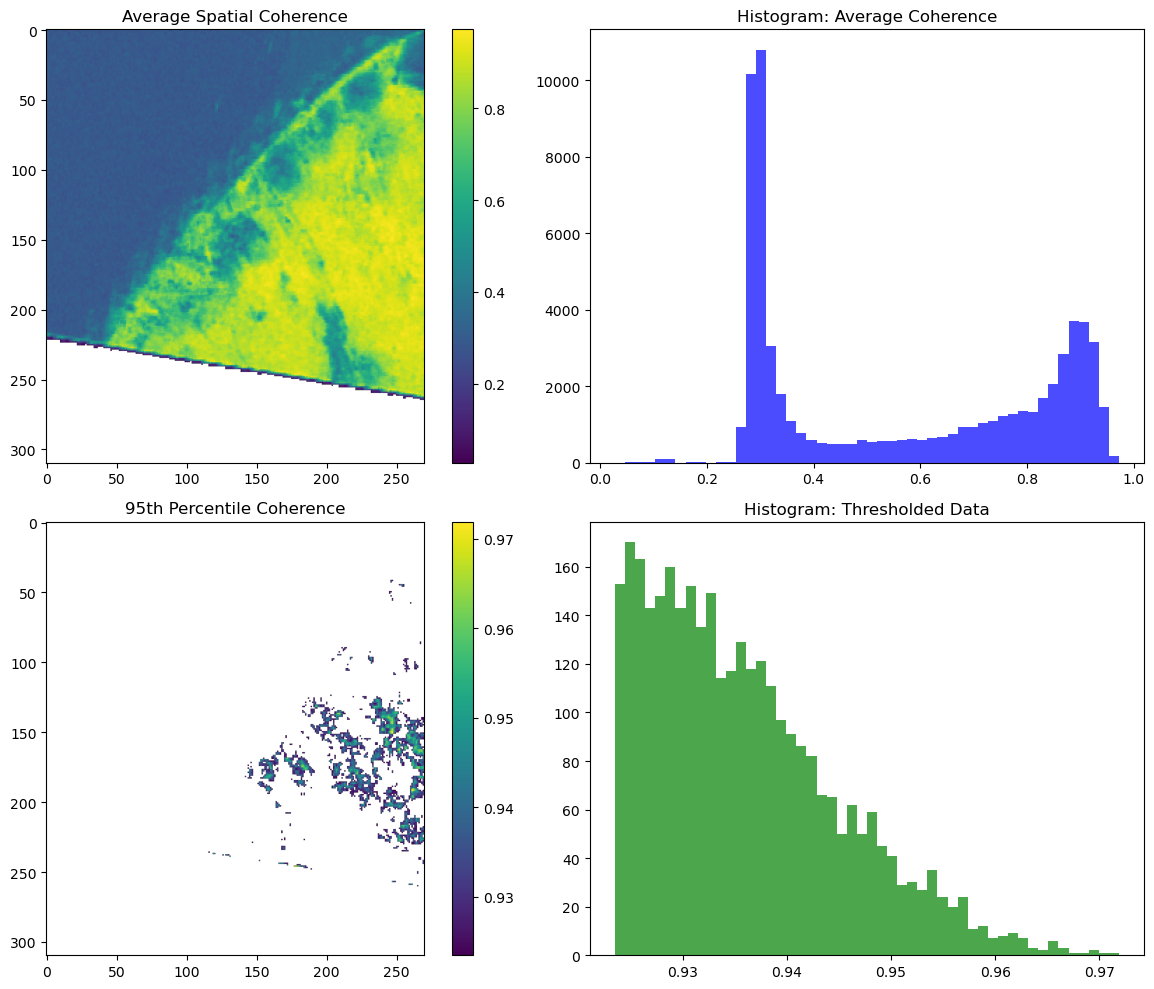

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Average Coherence
im1 = axs[0, 0].imshow(avgcoh, cmap='viridis')
axs[0, 0].set_title('Average Spatial Coherence')
fig.colorbar(im1, ax=axs[0, 0])

# Plot 2: Histogram of Average
axs[0, 1].hist(avgcoh.flatten(), bins=50, color='blue', alpha=0.7)
axs[0, 1].set_title('Histogram: Average Coherence')

# Plot 3: 95th Percentile Coherence
im2 = axs[1, 0].imshow(coherence95, cmap='viridis')
axs[1, 0].set_title('95th Percentile Coherence')
fig.colorbar(im2, ax=axs[1, 0])

# Plot 4: Histogram of 95th Percentile
axs[1, 1].hist(coherence95[~np.isnan(coherence95)], bins=50, color='green', alpha=0.7)
axs[1, 1].set_title('Histogram: Thresholded Data')

plt.tight_layout()
plt.show()

In [24]:
# Load the reference spatial info from your source TIF; will need to change date pair for input
with rasterio.open('./inputs/coherence-20250614_20250708.tif') as src:
    meta = src.meta.copy()
    transform = src.transform

# Prepare data for export: Replace NaN with the -9999 No-Data value
export_data = coherence95.copy()
export_data[np.isnan(export_data)] = -9999

# Update the metadata for the new file
meta.update({
    "driver": "GTiff",
    "dtype": 'float64',
    "nodata": -9999,
    "crs": CRS.from_epsg(32604) # UTM Zone 4N per your MATLAB script
})

# Write the new file
with rasterio.open('95percentcoh.tif', 'w', **meta) as dst:
    dst.write(export_data, 1)

print("File '95percentcoh.tif' created and ready for mapping.")

File '95percentcoh.tif' created and ready for mapping.


🛰️ Processing Geospatial Data...
✅ Visualization Ready!



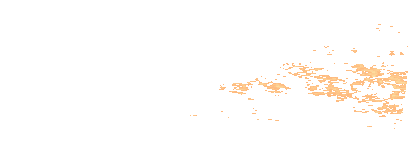


--- INSTRUCTIONS ---
1. Use the 'Stack' icon in the top right to toggle the coherence layer.
2. Click any pixel on the map to get its Latitude and Longitude.
3. To see the exact raw value, run: print(get_val(LAT_HERE, LON_HERE))


In [25]:
# --- 1. SETTINGS & PATHS ---
input_tif = '95percentcoh.tif'
wgs84_tif = '95percentcoh_wgs84.tif'
overlay_png = 'overlay.png'

print("🛰️ Processing Geospatial Data...")

# --- 2. REPROJECT TO WGS84 (Lat/Lon) ---
# Web maps require EPSG:4326 to align correctly with satellite basemaps
with rasterio.open(input_tif) as src:
    transform, width, height = calculate_default_transform(
        src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': 'EPSG:4326',
        'transform': transform,
        'width': width,
        'height': height,
        'dtype': 'float32'
    })

    with rasterio.open(wgs84_tif, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs='EPSG:4326',
                resampling=Resampling.nearest)

# --- 3. CREATE TRANSPARENT PNG OVERLAY ---
with rasterio.open(wgs84_tif) as src:
    data = src.read(1)
    # Define bounds for Folium [[lat_min, lon_min], [lat_max, lon_max]]
    bounds = [[src.bounds.bottom, src.bounds.left], [src.bounds.top, src.bounds.right]]
    center = [(src.bounds.bottom + src.bounds.top) / 2, (src.bounds.left + src.bounds.right) / 2]
    
    # Mask and Stretch (Focused on 0.5 to 1.0)
    mask = (data == -9999)
    # Normalize data for the colormap (stretching 0.5 - 1.0 range)
    data_norm = np.clip((data - 0.5) / (1.0 - 0.5), 0, 1)
    
    # Apply Magma colormap
    cmap = plt.get_cmap('magma')
    rgba_data = cmap(data_norm)
    rgba_data[mask, 3] = 0 # Set Alpha channel to 0 for transparency
    
    # Save as PNG
    img = Image.fromarray((rgba_data * 255).astype(np.uint8))
    img.save(overlay_png)

# --- 4. BUILD THE INTERACTIVE MAP ---
# Initialize Map centered on your data
m = folium.Map(location=center, zoom_start=14, control_scale=True)

# Add ESRI Satellite Imagery Basemap
esri_url = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
folium.TileLayer(
    tiles=esri_url,
    attr='Esri', 
    name='ESRI Satellite', 
    overlay=False
).add_to(m)

# Add the Coherence Overlay (The 'Drape')
folium.raster_layers.ImageOverlay(
    image=overlay_png,
    bounds=bounds,
    name='95% Coherence Overlay',
    opacity=0.8,
    interactive=True
).add_to(m)

# Add Legend (Color Bar)
colormap = cm.LinearColormap(
    colors=['#3b0f70', '#8c2981', '#de4968', '#fe9f6d', '#fcfdbf'], # Magma palette
    index=[0.5, 0.625, 0.75, 0.875, 1.0],
    vmin=0.5, vmax=1.0,
    caption='Coherence Value (95th Percentile Threshold)'
)
m.add_child(colormap)

# Add Click-to-Query Feature (LatLng Popups)
m.add_child(folium.LatLngPopup())

# Add Layer Control Toggle
folium.LayerControl().add_to(m)

# --- 5. DATA LOOKUP FUNCTION ---
def get_val(lat, lon):
    """Helper function to sample the raw data value at a specific coordinate"""
    with rasterio.open(wgs84_tif) as src_val:
        row, col = src_val.index(lon, lat)
        val = src_val.read(1)[row, col]
        if val == -9999:
            return f"Point ({lat:.5f}, {lon:.5f}): No Data (Below Threshold)"
        return f"Point ({lat:.5f}, {lon:.5f}): Coherence = {val:.4f}"

# Display Map
print("✅ Visualization Ready!")
display(m)

# Print instructions for students
print("\n--- INSTRUCTIONS ---")
print("1. Use the 'Stack' icon in the top right to toggle the coherence layer.")
print("2. Click any pixel on the map to get its Latitude and Longitude.")
print("3. To see the exact raw value, run: print(get_val(LAT_HERE, LON_HERE))")

In [26]:
print(get_val(71.2833, -156.6546))

Point (71.28330, -156.65460): Coherence = 0.9240


### Before setting our reference pixel, we should look at the coherence of the interferograms to see if we need to throw any out from the analysis

In [27]:
from mintpy.cli import view
view.main(['./inputs/ifgramStack.h5', 'coherence', '--nodisplay'])

run view.py in MintPy version 1.6.2, date 2025-07-07
input file is ifgramStack file: /home/jupyter/edc-research-demos/MintPy/inputs/ifgramStack.h5 in float32 format
file size in y/x: (310, 270)
input dataset: "['coherence']"
num of datasets in file ifgramStack.h5: 66
num of datasets to exclude: 0
num of datasets to display: 22
data   coverage in y/x: (0, 0, 270, 310)
subset coverage in y/x: (0, 0, 270, 310)
data   coverage in lat/lon: (575800.0, 7918200.0, 586600.0, 7905800.0)
subset coverage in lat/lon: (575800.0, 7918200.0, 586600.0, 7905800.0)
------------------------------------------------------------------------
colormap: gray
figure title: coherence
figure size : [15.00, 8.00]
dataset number: 22
row     number: 4
column  number: 7
figure  number: 1
consider reference pixel in y/x: [189, 204]
mark interferograms with 'dropIfgram=False' in red colored title
----------------------------------------
Figure 1 - coherence.png
reading data as a 3D matrix ...
data    range: [0.0, 0.9999

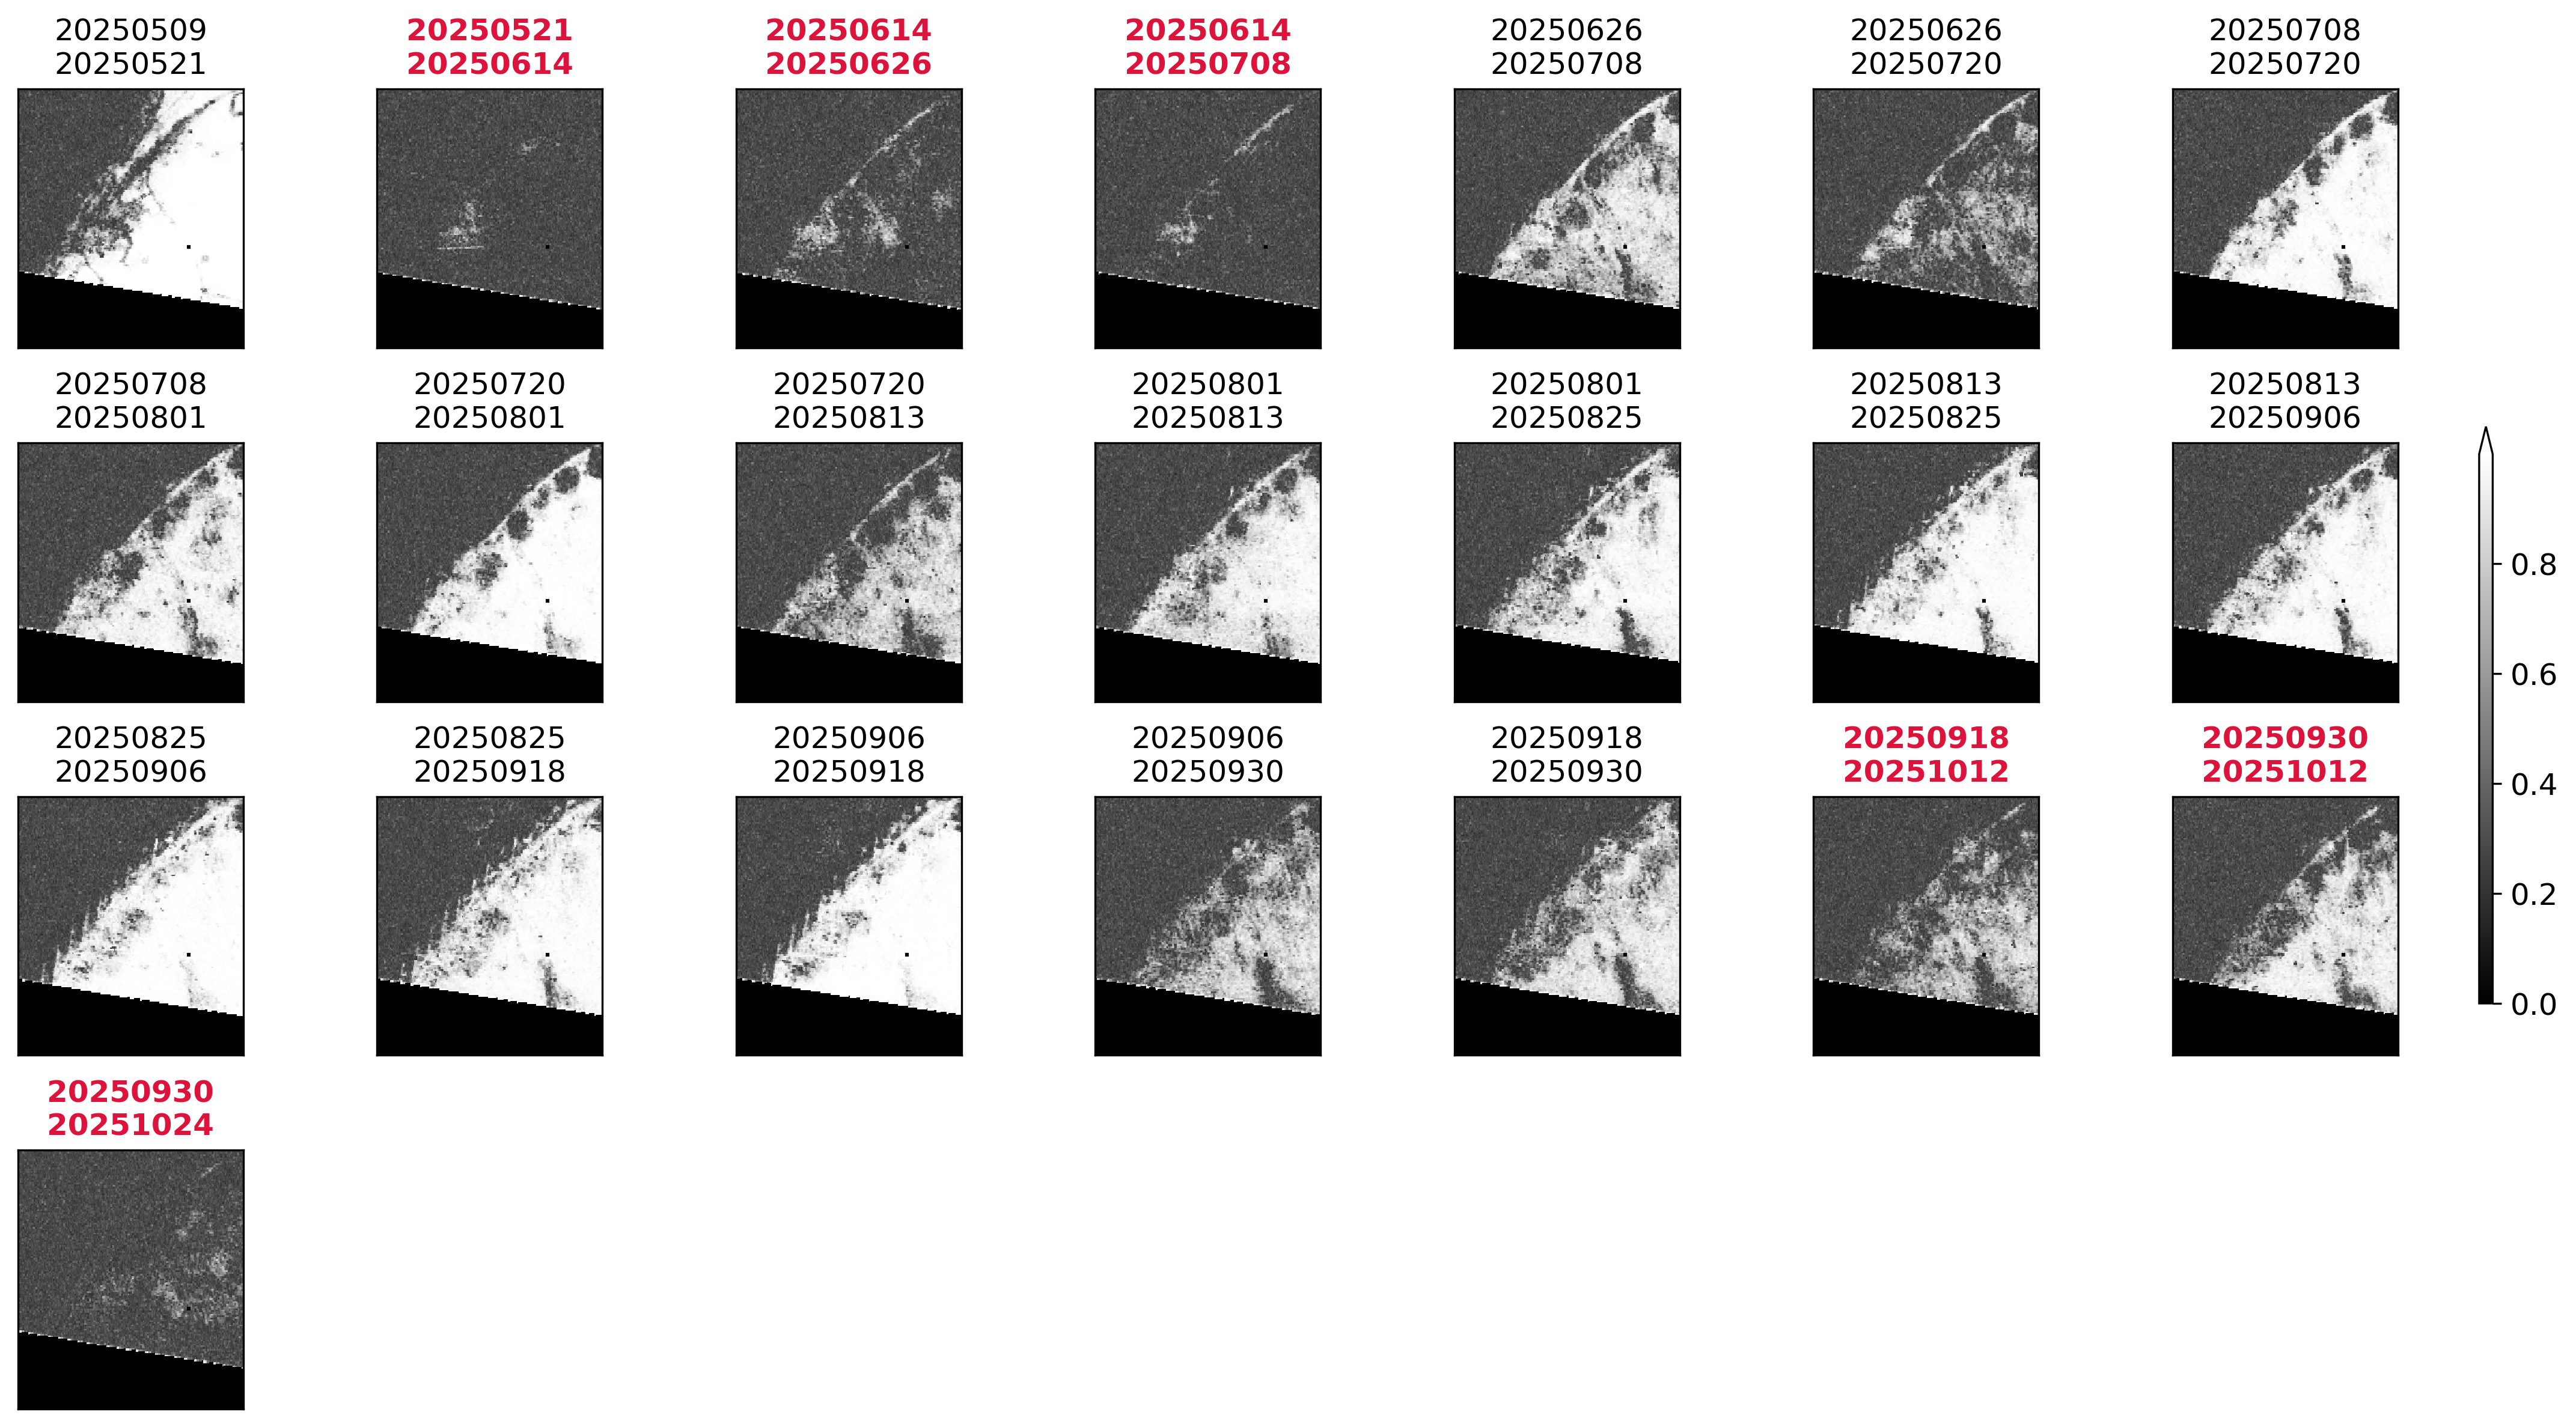

In [28]:
from IPython.display import Image, display

# Replace 'coherence.png' with the exact name generated by MintPy
display(Image(filename='coherence.png'))

### Based on the above coherence plot, it looks like interferogram 2, 3, and 4 look pretty poor, so I'm going to exclude them from the analysis.

### Now that we've used the map and function above, we can set our own reference pixel, exclude incoherent interferograms, and set our reference date (earliest date).

In [29]:
file_path = "utqiagvik_2025_v1.txt"

content_to_write = """mintpy.load.processor        = hyp3
##---------interferogram datasets:
mintpy.load.unwFile          = ../insar_results/extracted/*/*_unw_phase_clipped.tif
mintpy.load.corFile          = ../insar_results/extracted/*/*_corr_clipped.tif
mintpy.load.connCompFile     = ../insar_results/extracted/*/*_conncomp_clipped.tif
##---------geometry datasets:
mintpy.load.demFile          = ../insar_results/extracted/*/*_dem_clipped.tif
mintpy.load.incAngleFile     = ../insar_results/extracted/*/*_lv_theta_clipped.tif
mintpy.load.azAngleFile      = ../insar_results/extracted/*/*_lv_phi_clipped.tif
mintpy.load.waterMaskFile    = ../insar_results/extracted/*/*_water_mask_clipped.tif

mintpy.troposphericDelay.method = auto
##---------misc:
mintpy.plot = no
mintpy.network.coherenceBased  = yes  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
mintpy.network.minCoherence    = 0.2  #[0.0-1.0], auto for 0.7

mintpy.subset.lalo          = 71.2423460:71.3502273,-156.8757143:-156.5863262    #[S:N,W:E / no], auto for no

########## 2. modify_network
## 1) Network modification based on temporal/perpendicular baselines, date, num of connections etc.
mintpy.network.tempBaseMax     = 26  #[1-inf, no], auto for no, max temporal baseline in days
mintpy.network.startDate       = 20250501  #[20090101 / no], auto for no
mintpy.network.endDate         = 20251001  #[20110101 / no], auto for no
#mintpy.network.excludeIfgIndex = 15:17,19,33,34  #[1:5,25 / no], auto for no, list of ifg index (start from 0)
mintpy.network.excludeDate12   = 20250521_20250614,20250614_20250626,20250614_20250708  #[20080520_20090817 / no], auto for no

mintpy.network.coherenceBased  = yes  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
mintpy.network.minCoherence    = 0.2  #[0.0-1.0], auto for 0.7

########## 3. reference_point
mintpy.reference.lalo          = 71.28330,-156.65460   #[31.8,130.8 / auto]

########## 8. correct_troposphere (optional but recommended)
mintpy.troposphericDelay.method = auto  #[pyaps / height_correlation / gacos / no], auto for pyaps

########## 11.2 reference_date
## Reference all time-series to one date in time
## reference: Yunjun et al. (2019, section 4.9)
## no     - do not change the default reference date (1st date)
mintpy.reference.date = 20250509   #[reference_date.txt / 20090214 / no], auto for reference_date.txt"""

try:
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content_to_write)
    print(f"File '{file_path}' created successfully.")
except IOError as e:
    print(f"Error creating file: {e}")


File 'utqiagvik_2025_v1.txt' created successfully.


In [30]:
!smallbaselineApp.py utqiagvik_2025_v1.txt --start load_data --stop geocode


___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy 1.6.2, 2025-07-07
___________________________________________________________

--RUN-at-2026-02-13 18:46:56.609121--
Current directory: /home/jupyter/edc-research-demos/MintPy
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network', 'reference_point', 'quick_ov

📊 Auto-Scaled Range: -2.0 to 2.0 cm (Symmetric around zero)
✅ Success! Map saved to Alaska_InSAR_Dynamic_Map.html



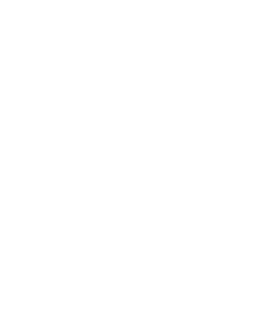
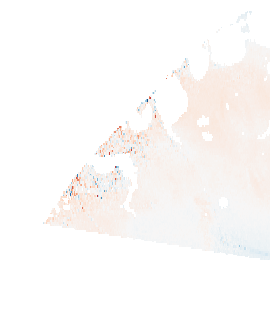
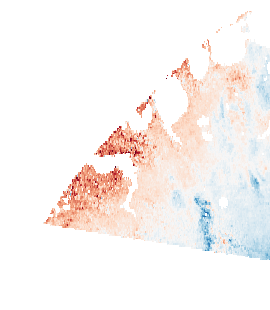
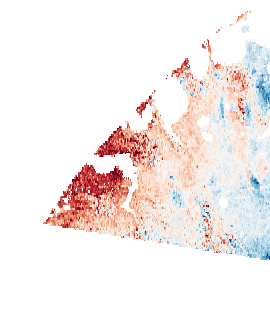
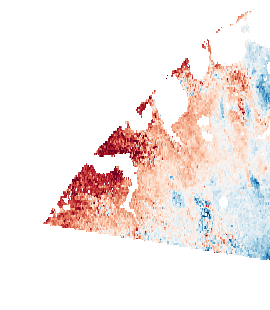
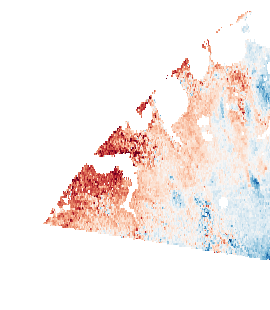
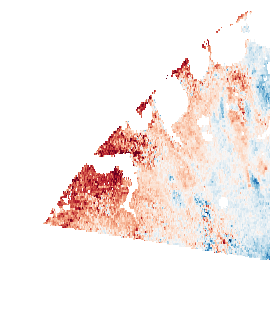
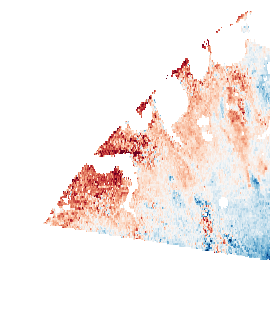
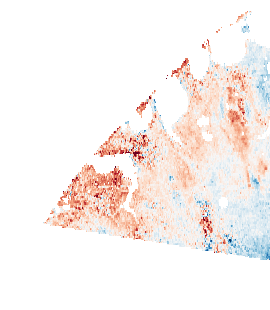
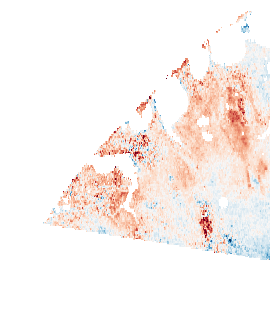
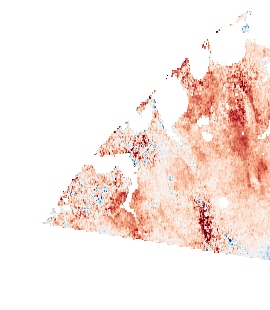

In [31]:
# --- SECTION 8: FINAL INTERACTIVE VISUALIZATION (AUTO-SCALED) ---
import folium
from folium import plugins
import branca.colormap as cm
from pyproj import Transformer
import PIL.Image as PILImage
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. HELPER FUNCTION ---
def add_point_marker(m, lat, lon, title="Point of Interest", color="red", icon="info-sign"):
    """Adds a marker with a Lat/Lon popup."""
    popup_text = f"<b>{title}</b><br>Lat: {lat:.6f}<br>Lon: {lon:.6f}"
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=title,
        icon=folium.Icon(color=color, icon=icon, prefix='fa')
    ).add_to(m)

# --- 2. CONFIGURATION & DATA LOADING ---
ts_file = Path('./timeseries_ERA5_demErr.h5')
source_epsg = "epsg:32604"  # Using the CRS confirmed for your data

if ts_file.exists():
    with h5py.File(ts_file, 'r') as f:
        data = f['timeseries'][:]
        dates = f['date'][:].astype(str)
        atr = dict(f.attrs)

    # --- 3. DYNAMIC COLORBAR CALCULATION ---
    # We use the final date (cumulative displacement) to set the scale
    final_slice_cm = data[-1, :, :] * 100
    # Filter out zeros (background) and NaNs for statistics
    valid_pixels = final_slice_cm[~np.isnan(final_slice_cm) & (final_slice_cm != 0)]
    
    if len(valid_pixels) > 0:
        # Use 2nd/98th percentile to avoid being skewed by noisy outliers
        v_min = np.percentile(valid_pixels, 2)
        v_max = np.percentile(valid_pixels, 98)
        # Force the colorbar to be symmetric around zero
        limit = max(abs(v_min), abs(v_max))
        # Round up slightly for a cleaner legend (e.g., 3.12 -> 4.0)
        limit = np.ceil(limit) if limit > 1 else np.round(limit, 1)
        vmin, vmax = -limit, limit
    else:
        vmin, vmax = -5, 5
    
    print(f"📊 Auto-Scaled Range: {vmin} to {vmax} cm (Symmetric around zero)")

    # --- 4. COORDINATE TRANSFORMATION ---
    transformer = Transformer.from_crs(source_epsg, "epsg:4326", always_xy=True)
    
    lat_first, lon_first = float(atr['Y_FIRST']), float(atr['X_FIRST'])
    lat_step, lon_step = float(atr['Y_STEP']), float(atr['X_STEP'])
    rows, cols = int(atr['LENGTH']), int(atr['WIDTH'])
    
    # Calculate corner points in degrees
    lon_min_deg, lat_min_deg = transformer.transform(min(lon_first, lon_first + (lon_step * cols)), 
                                                     min(lat_first, lat_first + (lat_step * rows)))
    lon_max_deg, lat_max_deg = transformer.transform(max(lon_first, lon_first + (lon_step * cols)), 
                                                     max(lat_first, lat_first + (lat_step * rows)))
    
    bounds = [[lat_min_deg, lon_min_deg], [lat_max_deg, lon_max_deg]]
    center = [(lat_min_deg + lat_max_deg) / 2, (lon_min_deg + lon_max_deg) / 2]

    # --- 5. MAP INITIALIZATION ---
    m = folium.Map(location=center, zoom_start=12)
    
    # Base Layers (overlay=False allows radio-button switching)
    folium.TileLayer('Esri.WorldImagery', name="Satellite Imagery", overlay=False).add_to(m)
    folium.TileLayer('openstreetmap', name="OpenStreetMap (Labels)", overlay=False).add_to(m)

    # Interactive Map Tools
    m.add_child(folium.LatLngPopup())
    plugins.Fullscreen().add_to(m)

    # Add Reference Point Marker
    if 'REF_LAT' in atr and 'REF_LON' in atr:
        ref_lon, ref_lat = transformer.transform(float(atr['REF_LON']), float(atr['REF_LAT']))
        add_point_marker(m, ref_lat, ref_lon, title="MintPy Reference Point", color="green", icon="star")

    # --- 6. LAYER GENERATION ---
    layer_list = []
    overlay_dir = Path('ts_overlays')
    overlay_dir.mkdir(exist_ok=True)
    
    # Define the colormap based on our dynamic limits
    colormap = cm.LinearColormap(
        colors=['blue', 'white', 'red'], 
        vmin=vmin, vmax=vmax, 
        caption="Cumulative Displacement (cm)"
    )

    for i, date_str in enumerate(dates):
        slice_data = data[i, :, :] * 100 
        mask = (slice_data == 0) | (np.isnan(slice_data))
        
        # Normalize and apply colormap
        norm_data = np.clip((slice_data - vmin) / (vmax - vmin), 0, 1)
        rgba_data = plt.get_cmap('RdBu_r')(norm_data)
        rgba_data[mask, 3] = 0 # Set transparency
        
        png_path = overlay_dir / f"ts_{date_str}.png"
        PILImage.fromarray((rgba_data * 255).astype(np.uint8)).save(png_path)
        
        # Add overlay (show=False so map starts with clean satellite imagery)
        overlay = folium.raster_layers.ImageOverlay(
            image=str(png_path), bounds=bounds, name=f"📅 {date_str}", 
            opacity=0.7, show=False
        )
        overlay.add_to(m)
        layer_list.append(overlay)

    # --- 7. DUAL CONTROLS & EXPORT ---
    # Grouped control for the InSAR time steps
    plugins.GroupedLayerControl(groups={"InSAR Time-Series": layer_list}, collapsed=False).add_to(m)
    # Standard control for the Satellite vs OSM toggle
    folium.LayerControl(position='topright', collapsed=True).add_to(m)
    
    m.add_child(colormap)
    
    output_file = "Alaska_InSAR_Dynamic_Map.html"
    m.save(output_file)
    print(f"✅ Success! Map saved to {output_file}")
    display(m)

else:
    print("⏳ timeseries file not found. Please complete the MintPy processing steps first.")

In [32]:
ts_file = Path('./timeseries_ERA5_demErr.h5')

if ts_file.exists():
    with h5py.File(ts_file, 'r') as f:
        data = f['timeseries'][:]
        dates = f['date'][:].astype(str)
    
    # 1. Conversion and Range Setup
    data_cm = data * 100
    # Use the same percentile logic to keep limits consistent with the map
    final_pixels = data_cm[-1, :, :][~np.isnan(data_cm[-1, :, :]) & (data_cm[-1, :, :] != 0)]
    limit = np.ceil(max(abs(np.percentile(final_pixels, 2)), abs(np.percentile(final_pixels, 98))))
    if limit == 0: limit = 5 # Safety fallback
    
    # 2. Grid Setup
    num_dates = len(dates)
    cols = 3
    rows = int(np.ceil(num_dates / cols))
    
    # Create figure with shared axes
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3.5), sharex=True, sharey=True)
    axes = axes.flatten()
    
    print(f"📈 Generating histograms with a fixed X-range of ±{limit} cm...")

    # 3. Plotting Loop
    for i in range(num_dates):
        # Extract valid pixels for this date
        pixels = data_cm[i, :, :].flatten()
        pixels = pixels[~np.isnan(pixels) & (pixels != 0)]
        
        # Plot Histogram
        # Using 50 bins for detail; alpha for clarity
        axes[i].hist(pixels, bins=50, range=(-limit, limit), color='skyblue', edgecolor='black', alpha=0.7)
        
        # Add a zero-line for reference
        axes[i].axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')
        
        # Label with Date
        axes[i].set_title(f"Date: {dates[i]}", fontsize=12, fontweight='bold')
        axes[i].grid(axis='y', linestyle=':', alpha=0.6)

    # 4. Final Formatting
    fig.suptitle('Evolution of Surface Deformation Distribution (Northern Alaska)', fontsize=18, y=1.02)
    fig.text(0.5, -0.02, 'Cumulative Displacement (cm)', ha='center', fontsize=14, fontweight='bold')
    fig.text(-0.02, 0.5, 'Frequency (Pixel Count)', va='center', rotation='vertical', fontsize=14, fontweight='bold')
    
    # Hide empty subplots if num_dates is not a perfect multiple of 'cols'
    for j in range(num_dates, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    
    # Save a high-res version for reports
    plt.savefig('insar_displacement_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("⏳ Timeseries file not found. Ensure MintPy processing is complete.")

📈 Generating histograms with a fixed X-range of ±2.0 cm...
